In [1]:
import pandas as pd 
import numpy as np

# for timestamps
from datetime import datetime
# from datetime import timedelta

# imports to find autocorrelation plots
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# imports for partial autocorrelation plots
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#decomposing time series
from statsmodels.tsa.seasonal import seasonal_decompose

# for plotting
import matplotlib.pyplot as plt

#for adfuller test
from statsmodels.tsa.stattools import adfuller

# for performance metrics
from sklearn.metrics import mean_squared_error

## NHS SARIMA Forecast for general admissions

The aim is to give forecasts of admission numbers in any given month so nursing staff/doctors/etc can be managed accordingly, this will help inform planning by NHS management.

There are many possible benefits that come as bi-products of management being better informed.

These may include:
- Happier/longer serving staff as appropriate staff numbers are used in busy periods burn-out/boredom is avoided
- Better value for the tax payer, expensive agency staff are not being brought in when they are not needed
- Budgeting can be more precise as a result of thge two above (less advertising,agency staff,wasted resources)
- Prior warning before big spikes will allow wards to move patients around ahead of time to use the ful capacity.

## Creating SARIMA/ARIMA models - workflow

Our goals/ requirements to use a SARIMA model are as follows

- Our data must be continuous with out any breaks and must have a constant frequency (daily,weekly,monthly)
- Our data is stationary, this means No trends and no seasonality
- Our data is homscedastic which means that it's of the same variance throughout 

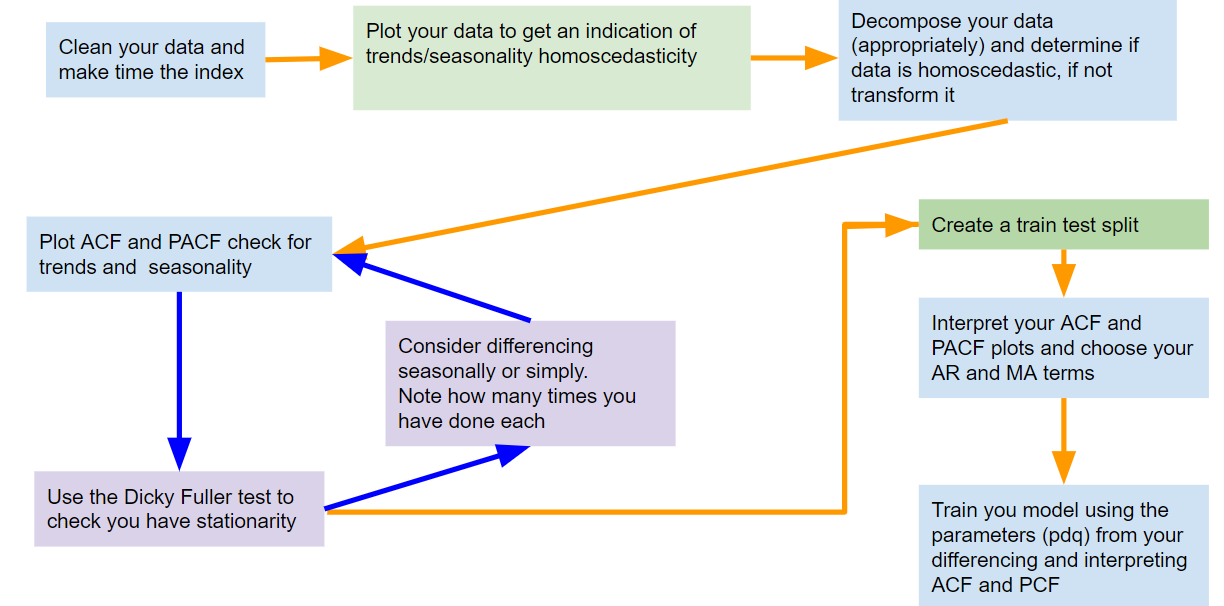

## Load in the data

In [2]:
path = './data/nhsdata.xls'

# format of dat is excel 1993 so slightly different loading pocess
# read_excel can read a multitude of excel formats, this can save time if you don't want to have to export to csv
admissions = pd.read_excel(path)

In [3]:
# check what we've got
admissions.head()

,Year,Period,Elective G&A Ordinary Admissions (FFCEs)
0,2008-09,APRIL,146612
1,2008-09,MAY,142716
2,2008-09,JUNE,143681
3,2008-09,JULY,153151
4,2008-09,AUGUST,134442


### 1. EDA and data cleaning

- Check our data see what it includes
- Clean any nulls/type issues
- Get dates in to the correct format (datetime)
- make date the index

In [4]:
# see what data types are in our dataset
admissions.dtypes

Year                                        object
Period                                      object
Elective G&A Ordinary Admissions (FFCEs)     int64
dtype: object

In [5]:
# rename the long and difficult to type column headers 
admissions.columns = ['year','period','no_admissions']
admissions.head()

,year,period,no_admissions
0,2008-09,APRIL,146612
1,2008-09,MAY,142716
2,2008-09,JUNE,143681
3,2008-09,JULY,153151
4,2008-09,AUGUST,134442


In [6]:
# datesinclude a from to, we can strip this out by processing the date as astring and cutting the last three characters
# cleaning like this may takemany forms and can use many libraries but in this case this is porbably the most simple
admissions['year'] = admissions['year'].apply(lambda x: x[:-3])

# lambda (above) is a single use function you give it a variable x in this vase our date time 
# and it returns whatever you put after the colon

# Note you can complete the process using a cobventional function 
admissions.head()

,year,period,no_admissions
0,2008,APRIL,146612
1,2008,MAY,142716
2,2008,JUNE,143681
3,2008,JULY,153151
4,2008,AUGUST,134442


In [7]:
admissions.tail()

,year,period,no_admissions
115,2017,NOVEMBER,124343
116,2017,DECEMBER,103063
117,2017,JANUARY,98849
118,2017,FEBRUARY,102861
119,2017,MARCH,112428


In [8]:
# combine the month and year to get the date
admissions['date'] = admissions['period'] + '-' + admissions['year']
#admissions['date2'] = f"{admissions['period']}-{admissions['year']}"
admissions.head()

,year,period,no_admissions,date
0,2008,APRIL,146612,APRIL-2008
1,2008,MAY,142716,MAY-2008
2,2008,JUNE,143681,JUNE-2008
3,2008,JULY,153151,JULY-2008
4,2008,AUGUST,134442,AUGUST-2008


In [9]:
# check the result
admissions.head()

,year,period,no_admissions,date
0,2008,APRIL,146612,APRIL-2008
1,2008,MAY,142716,MAY-2008
2,2008,JUNE,143681,JUNE-2008
3,2008,JULY,153151,JULY-2008
4,2008,AUGUST,134442,AUGUST-2008


In [10]:
# check for nulls
admissions.isnull().sum().sum()

0

In [11]:
# checkl our dtypes onlast time to see if we need to use datetime
admissions.dtypes

year             object
period           object
no_admissions     int64
date             object
dtype: object

### 2. Set time as index

In [12]:
# recast date as a datetime 
admissions['date'] = pd.to_datetime(admissions['date'])

In [13]:
admissions.dtypes

year                     object
period                   object
no_admissions             int64
date             datetime64[ns]
dtype: object

In [14]:
admissions.head()

,year,period,no_admissions,date
0,2008,APRIL,146612,2008-04-01
1,2008,MAY,142716,2008-05-01
2,2008,JUNE,143681,2008-06-01
3,2008,JULY,153151,2008-07-01
4,2008,AUGUST,134442,2008-08-01


In [15]:
# make date the index
admissions.set_index('date',inplace=True)

In [16]:
# check this has worked
admissions.head()

,year,period,no_admissions
date,,,
2008-04-01,2008,APRIL,146612
2008-05-01,2008,MAY,142716
2008-06-01,2008,JUNE,143681
2008-07-01,2008,JULY,153151
2008-08-01,2008,AUGUST,134442


In [17]:
admissions.index

DatetimeIndex(['2008-04-01', '2008-05-01', '2008-06-01', '2008-07-01',
               '2008-08-01', '2008-09-01', '2008-10-01', '2008-11-01',
               '2008-12-01', '2008-01-01',
               ...
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01'],
              dtype='datetime64[ns]', name='date', length=120, freq=None)

In [18]:
# for timesaeries work it is useful to make sure python knows what the frequecny is to ensure this use resample
admissions = admissions.resample('M').pad()

In [19]:
admissions.index

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=120, freq='M')

### 3. plot to check for trends and seasonality

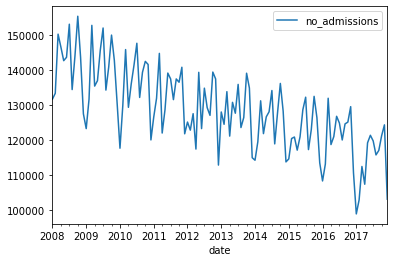

In [20]:
admissions.plot();

<Figure size 432x432 with 0 Axes>

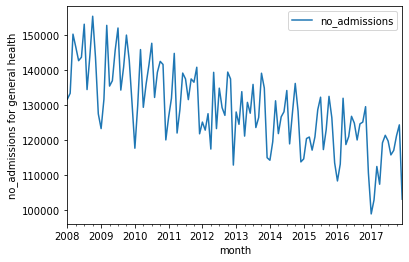

In [24]:
# create a simple plot
#simple plot
#admissions.plot()

#plotting with some nice options
plt.figure(figsize = (6,6))

ax = admissions.plot(y = 'no_admissions', use_index = True)

ax.set_xlabel('month')
ax.set_ylabel('no_admissions for general health');

### 4. Decompose your timeseries

(IMPORTANT NOTE: **DO NOT** use these functions unless you are sure you have a seasonal pattern if not use a moving average to decompose)

<Figure size 432x288 with 0 Axes>

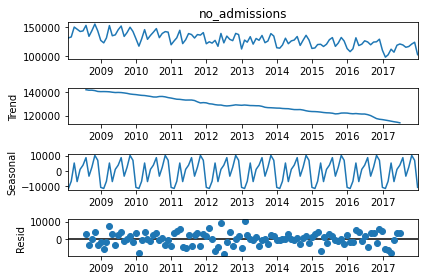

In [25]:
# when decomposing make sure the period matches the number of time periods match the seasonality you think you have spotted 
decomposition = seasonal_decompose(admissions['no_admissions'], period = 12)  


fig = plt.figure()  
fig = decomposition.plot()

# A general check is your trend line, if it has seasonality in it you need to tweak the period settings for your decomposition

<AxesSubplot:xlabel='date'>

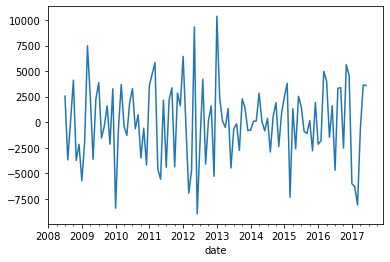

In [26]:
decomposition.resid.plot()

### 5. Acheive a stationary time series
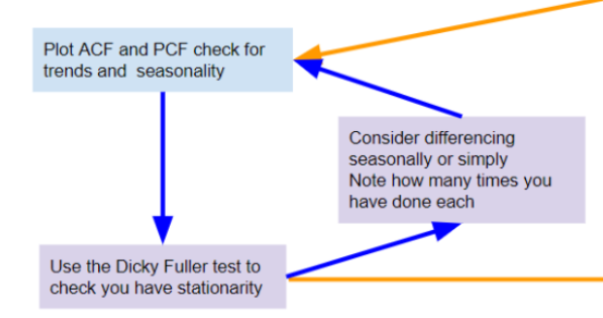

This is repetitive process you keep going until you are left with a stationary time series that means;
- No trend
- No seasonal pattern
- Homoscedastic

In [31]:
#Dicky Fuller to check stationarity

stationary_test = adfuller(admissions['no_admissions'])
# looks like we don't have a stationary timeseries as the p-value is > 0.05

stationary_test[1]

# we could already tell that it wasn't stationary

0.9906540628580542

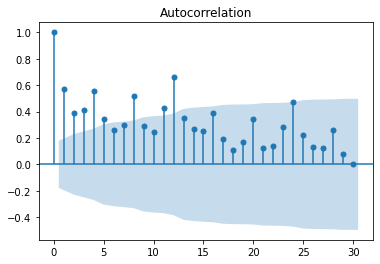

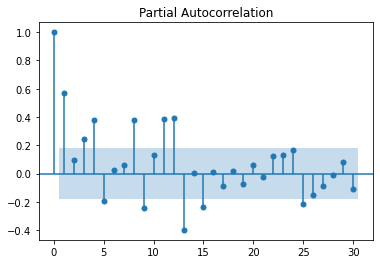

In [28]:
# plot ACF and PACF to see patterns in lags
plot_acf(admissions['no_admissions'],lags=30);
plot_pacf(admissions['no_admissions'],lags = 30);

In [29]:
# looks like seasonality is strong and the trend is really clear in the ACF 
# apply differencing seasonally 12 months so period is 12
admissions['seasonaL_differenced'] = admissions['no_admissions'].diff(12)


admissions.head(14)

,year,period,no_admissions,seasonaL_differenced
date,,,,
2008-01-31,2008,JANUARY,131703,NaN
2008-02-29,2008,FEBRUARY,133384,NaN
2008-03-31,2008,MARCH,150306,NaN
2008-04-30,2008,APRIL,146612,NaN
2008-05-31,2008,MAY,142716,NaN
2008-06-30,2008,JUNE,143681,NaN
2008-07-31,2008,JULY,153151,NaN
2008-08-31,2008,AUGUST,134442,NaN
2008-09-30,2008,SEPTEMBER,144065,NaN


<AxesSubplot:xlabel='date'>

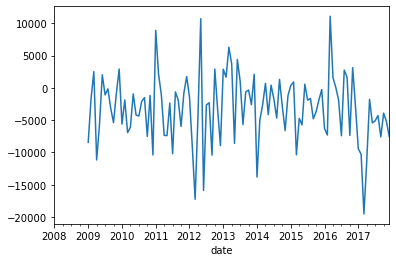

In [32]:
# Visual check for trend and seasonality to corroborate ADF test
admissions['seasonaL_differenced'].plot()

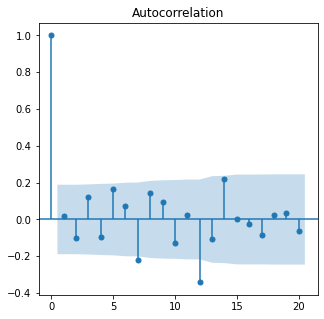

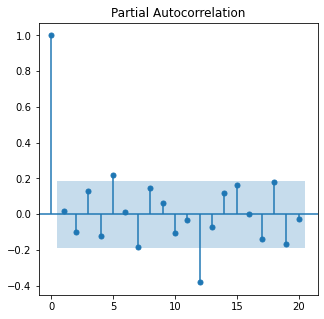

In [33]:
# store differenced data in a variable for quick access later
seasonal_dif = admissions['seasonaL_differenced'].dropna()



# plot the ACF and PACF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(seasonal_dif,lags=20, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(seasonal_dif,lags = 20, ax =ax);
plt.show()

In [34]:
#Dicky Fuller to check stationarity

stationary_test = adfuller(seasonal_dif)
# looks like we have a stationary timeseries as the p-value is < 0.05

stationary_test[1]

0.0003193934202344037

## We could go straight to the next stage but here we have an oportunity to explore overdifferencing

In [35]:
# Do a simople differencing as we saw a trend too, even though the seasonal differencing addressed this we can difference agin
admissions['over_differenced'] = admissions['seasonaL_differenced'].diff()
admissions.head()

,year,period,no_admissions,seasonaL_differenced,over_differenced
date,,,,,
2008-01-31,2008,JANUARY,131703,NaN,NaN
2008-02-29,2008,FEBRUARY,133384,NaN,NaN
2008-03-31,2008,MARCH,150306,NaN,NaN
2008-04-30,2008,APRIL,146612,NaN,NaN
2008-05-31,2008,MAY,142716,NaN,NaN


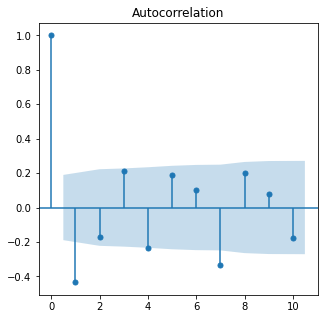

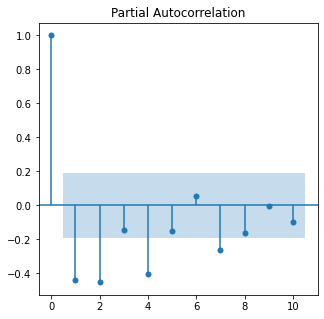

In [36]:
over_dif = admissions['over_differenced'].dropna()



# plot the ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(over_dif,lags=10, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(over_dif,lags = 10, ax =ax);
plt.show()

In [37]:
#Dicky Fuller to check stationarity

stationary_test = adfuller(over_dif)
# looks like we have a stationary timeseries as the p-value is < 0.05

stationary_test[1]

6.1023625994901737e-05

#### You can see this has altered our ACF and PACF, we will sompare what this has done to the model later

### 6. Train test split

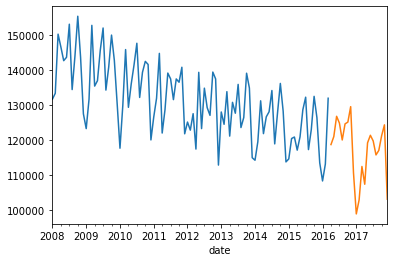

In [44]:
# set how many data points to go in to our training set
train_size = 99


# use iloc to slice the data at the correct number of data points
train = admissions['no_admissions'].iloc[:train_size]


test = admissions['no_admissions'].iloc[train_size:]
# try to avoid splits at major changes in your data it can confuse your model, 
# it is better to go back or forward a few data points rather than stick religiously
# to a 70/30 split



# visualise the train-test split to check it seems reasonable
#fig, ax1 = plt.subplots(1, 1)
#train.plot(ax=ax1)
#test.plot(ax=ax1)
#plt.show();
plt.subplots(1, 1)
train.plot()
test.plot();

# IF you transform you timeseries you must use the transformed version to train the model (see the airline example)
# blue is training data orange is testing data

## 7. Interpret ACF and PACF to find (pdq) and (pdqs) terms

- Plot the ACF and PACF of your stationaru tiome series 
- In this case we have 2 stationary series seasonal;ly_differenced and over_differenced so we need two sets of plots
- Then we follow the flow below to find the best first recommended model(some tweaking is sometimes useful)

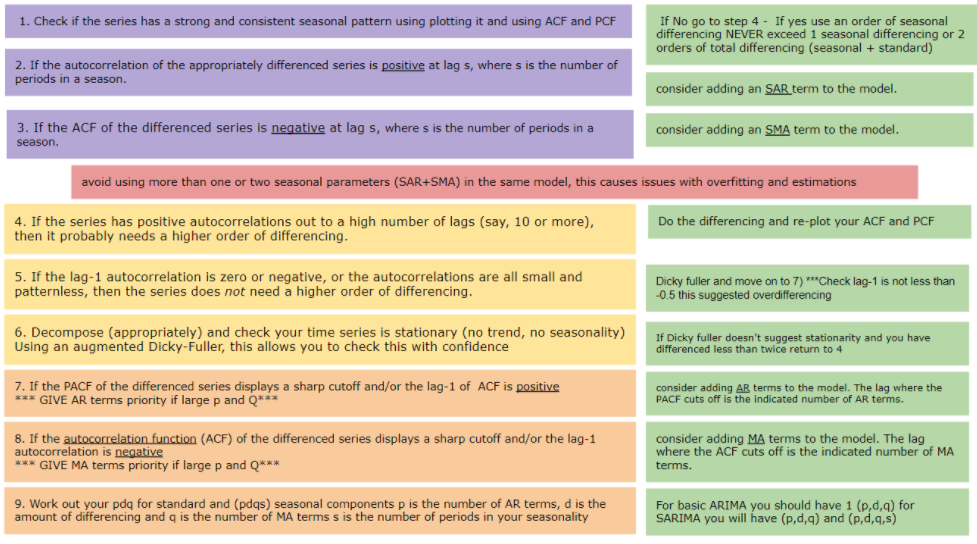

### Interpreting for seasonal_dif 

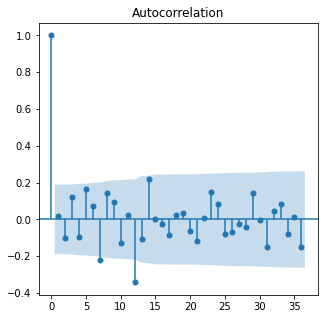

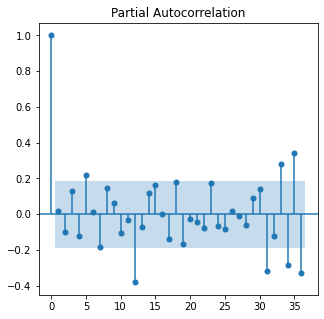

In [45]:
# plot the ACF and PACF
# then use the rules above to help you interperet your ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(seasonal_dif,lags=36, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(seasonal_dif,lags = 36, ax =ax);
plt.show()

### Seasional component (consider every 12th lag)

- first seasonal spike is negative so suggests SMA(seasonal moving average) is best
- seasonal spikes at 12 only suggest SMA 1
- differencing was 1
- period was 12
- (0,1,1,12) is the (p,d,q,s) of our seasonal part of the model


### ARIMA component (consider all lags)

- first ACF spike is positive so suggests AR terms are best
- no significant lags as the PACF becomes insignificant at lag 1
- Differencing was 0
- (0,0,0) is the (p,d,q) of our non-seasonal part of the model

## Now we can train a model using these.......

### Interpreting for over_dif 

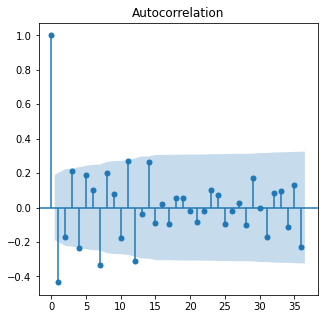

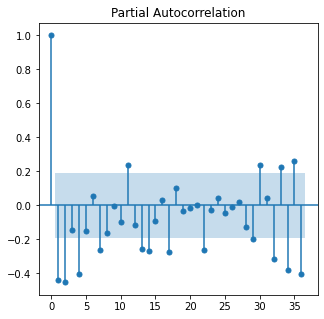

In [46]:
# plot the ACF and PCF
# then use the rules above to help you interperet your ACF and PCF
fig, ax = plt.subplots(figsize=(5, 5))
plot_acf(over_dif,lags=36, ax=ax);
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
plot_pacf(over_dif,lags = 36, ax =ax);
plt.show()

### Seasional component (consider every 12th lag)

- first seasonal spike is negative so suggests SMA(seasonal moving average) is best
- seasonal spikes at 12 only suggest SMA 1
- differencing was 1
- period was 12
- (0,1,0,12) is the (p,d,q,s) of our seasonal part of the model


### ARIMA component (consider all lags)

- first ACF spike is negative so suggests MA terms are best
- 1 significant lags as the PACF becomes insignificant at lag 2
- Differencing was 1
- (0,1,1) is the (p,d,q) of our non-seasonal part of the model

### 8. Build model

In [47]:
# building the model is easy we just input our pdq and pdqs in to the SARIMAX model.
# Note to turn the SARIMAX into an ARIMA for non-seasonal data use fit1 = SARIMAX(train, order=(0,1,1)).fit()
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA

test_size = len(admissions.index) - train_size #we set this as 99


# fit the models
#seasonal model
fit_dif = SARIMAX(train, order = (0,0,0) ,seasonal_order=(0,1,1,12)).fit()

#over differenced model
fit_over_dif = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,0,12)).fit()


# create the forecasts

# Seaonal model
forecast1 = fit_dif.get_forecast(test_size).summary_frame(alpha=0.1)

# Over diferrenced model
forecast2 = fit_over_dif.get_forecast(test_size).summary_frame(alpha=0.1)



In [48]:
forecast1.head()

no_admissions,mean,mean_se,mean_ci_lower,mean_ci_upper
2016-04-30,117199.169127,5852.055772,107573.393965,126824.944290
2016-05-31,121021.317614,5852.055772,111395.542452,130647.092776
2016-06-30,128658.303001,5852.055772,119032.527839,138284.078163
2016-07-31,132299.876086,5852.055772,122674.100924,141925.651248
2016-08-31,117294.562920,5852.055772,107668.787758,126920.338082


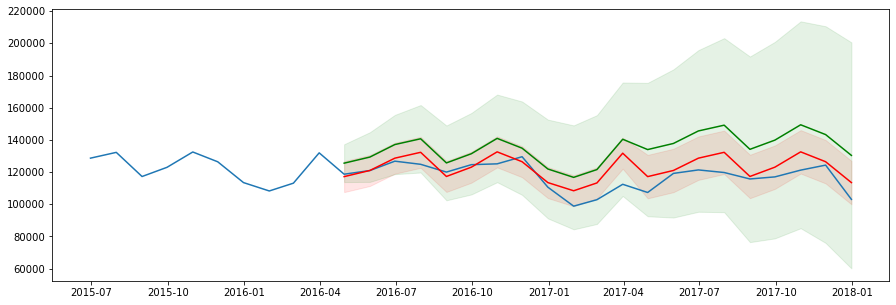

In [49]:
# for the twice_differenced model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data (last 10 before the split) this let's us view the forecast better
ax.plot(admissions.index[train_size-10:], admissions['no_admissions'][train_size-10:])




# plot the forecasts
ax.plot(admissions.index[-test_size:], forecast1['mean'], color = 'r')
ax.plot(admissions.index[-test_size:], forecast2['mean'], color = 'g')

# plot the confidence intervals on the forecasts
ax.fill_between(admissions.index[-test_size:], forecast1['mean_ci_lower'], forecast1['mean_ci_upper'], color='r', alpha=0.1);
ax.fill_between(admissions.index[-test_size:], forecast2['mean_ci_lower'], forecast2['mean_ci_upper'], color='g', alpha=0.1);


### 9. Evaluate performance

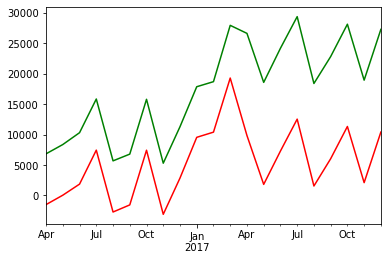

In [50]:
# Take the residuals of your prediction vs the actual values
# if the model has captured all of the signal the residuals will just look like random noise
# if there is a trend in the residuals we should try to develop our model further

# find residuals for seasonal model
resid1 = forecast1['mean'] - test
resid1.plot(color = 'r');

# find residuals for over differenced model
resid2 = forecast2['mean'] - test
resid2.plot(color = 'g');

### Looking at residuals

- residuals for model two have a trend and an average above zero, this suggests that we have not fully captured the "signal" of  our timeseries and that the model overpredicts at the start and gets gradually worse!
- residuals for model 1 a far better, the average is slightly above 0 but minimal trend it is a far better model, this sholws taht initial predictions are quite accurate with a slight tendency to over predict later.

In [51]:
#We could even use Dicky Fuller to check if the residuals are stationary

stationary_test1 = adfuller(resid1)
# looks like we have a stationary timeseries as the p-value is < 0.05
stationary_test2 = adfuller(resid2)

# we can see that the residuals from the seasonal model are stationary(suggests we have made a good model)
# the residuals from the over differenced model have a trend so are not stationary (this suggests we should revisit our data)
print(stationary_test1[1],stationary_test2[1])

0.009621668932964142 0.5913284379451749


In [52]:
a = mean_squared_error(test, forecast1['mean'])
b = mean_squared_error(test, forecast1['mean'], squared = False)

c = mean_squared_error(test, forecast2['mean'])
d = mean_squared_error(test, forecast2['mean'], squared = False)



print(f'model 1 with 1 levels seasonal differencing only, had an mse of: {a} and an RMSE of: {b}\n\n')
print(f'model 2 with 2 levels of differencing had an mse of: {c} and an RMSE of: {d}')

model 1 with 1 levels seasonal differencing only, had an mse of: 62352986.81577771 and an RMSE of: 7896.390746143311


model 2 with 2 levels of differencing had an mse of: 365744762.2565646 and an RMSE of: 19124.4545610212


### 10. Deploy your model to forecast

#### Once we're happy with the model apply it to the whole dataset


In [57]:
# this time use the whole data set
fit_dif = SARIMAX(admissions['no_admissions'], order=(0,0,0), seasonal_order=(0,1,0,12)).fit()

# you probably wouldn't use this
fit_over_dif = SARIMAX(admissions['no_admissions'], order=(0,1,1), seasonal_order=(0,1,1,12)).fit()



# window how far to forecast
window = 10

# get forecast for our window
forecast1 = fit_dif.get_forecast(window).summary_frame(alpha=0.1)
forecast2 = fit_over_dif.get_forecast(window).summary_frame(alpha=0.1)
    

In [58]:
forecast1.head()

no_admissions,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-31,98849.0,6054.928403,88889.529055,108808.470945
2018-02-28,102861.0,6054.928403,92901.529055,112820.470945
2018-03-31,112428.0,6054.928403,102468.529055,122387.470945
2018-04-30,107342.0,6054.928403,97382.529055,117301.470945
2018-05-31,119200.0,6054.928403,109240.529055,129159.470945


In [59]:
# using the last value of the passengers as the values for the starting row of the forecast dataframe
new_row = {
    'mean': admissions['no_admissions'][-1],
    'mean_ci_lower': admissions['no_admissions'][-1],
    'mean_ci_upper': admissions['no_admissions'][-1],
}

# using the last date in the dataframe
new_index = admissions.index[-1]

# appending new row at the index above
forecast1.loc[new_index] = new_row


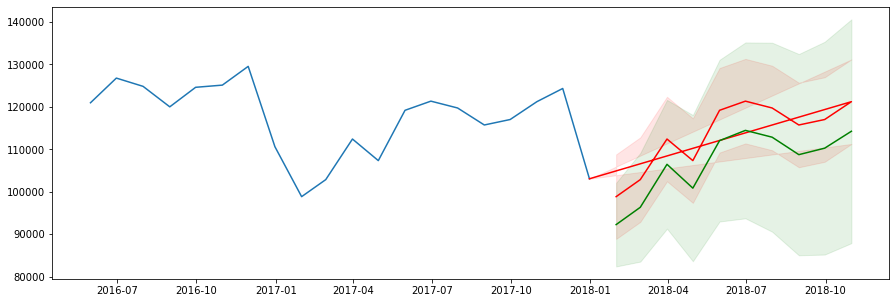

In [60]:
# for the twice_differenced model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data
ax.plot(admissions.index[-20:], admissions['no_admissions'][-20:])

# plot the forecasts
ax.plot(forecast1['mean'], color = 'r')
ax.plot(forecast2['mean'], color = 'g')

# plot the confidence intervals on the forecasts
ax.fill_between(forecast1.index, forecast1['mean_ci_lower'], forecast1['mean_ci_upper'], color='r', alpha=0.1);
ax.fill_between(forecast2.index, forecast2['mean_ci_lower'], forecast2['mean_ci_upper'], color='g', alpha=0.1);
